<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#데이터-상세" data-toc-modified-id="데이터-상세-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>데이터 상세</a></span></li><li><span><a href="#데이터-불러오기,-결측치-확인" data-toc-modified-id="데이터-불러오기,-결측치-확인-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>데이터 불러오기, 결측치 확인</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#시간" data-toc-modified-id="시간-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>시간</a></span></li><li><span><a href="#상점" data-toc-modified-id="상점-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>상점</a></span></li><li><span><a href="#거래" data-toc-modified-id="거래-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>거래</a></span></li></ul></li><li><span><a href="#feature-engineering" data-toc-modified-id="feature-engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>feature engineering</a></span></li></ul></div>

In [164]:
# libraries
import numpy as np  # linear algebra
import pandas as pd  # file i/o

import matplotlib.pyplot as plt  # plot
import seaborn as sb  # plot

import datetime  # date to weekday
# find korean hollyday

plt.rcParams['figure.figsize'] = [12, 5]  # set default figure size
plt.rcParams['font.size'] = 8
plt.rc('font', family='Malgun Gothic')  # 한글 폰트 설정

# show all columns and rows in pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## 데이터 상세
* train set
    * 20160601 - 20190228 카드거래데이터

* 목적
    * 20190301 - 20190531 상점별 3개월 총 매출 예측
* data fields
    * 시간
        * trasacted_date: 거래 날짜
        * transacted_time: 거래 시간( 시:분 )
    * 상점
        * store_id: 상점의 고유 아이디
        * region: 상점의 지역
        * type_of_business: 상점의 업종
    * 거래
        * card_id: 사용한 카드의 고유 아이디
        * card_company: 비식별화된 카드 회사
        * installment_term: 할부 개월 수( 포인트 사용 시 (60개월 + 실제할부개월)을 할부개월수에 기재한다. )
        * amount: 거래액(단위는 원이 아닙니다)

## 데이터 불러오기, 결측치 확인

In [30]:
# 데이터 불러오기
route = 'D:\document\data\predict_funda_sales_dacon'

train_df = pd.read_csv(f'{route}\\funda_train.csv')
submission_df = pd.read_csv(f'{route}\\submission.csv')

print(f'''
train: {train_df.shape}
submission: {submission_df.shape}
''')


train: (6556613, 9)
submission: (1967, 2)



In [31]:
# 데이터 확인
display(train_df.head())
display(submission_df.head())

store_id  card_id card_company transacted_date transacted_time  installment_term region type_of_business       amount
0         0        0            b      2016-06-01           13:13                 0    NaN           기타 미용업  1857.142857
1         0        1            h      2016-06-01           18:12                 0    NaN           기타 미용업   857.142857
2         0        2            c      2016-06-01           18:52                 0    NaN           기타 미용업  2000.000000
3         0        3            a      2016-06-01           20:22                 0    NaN           기타 미용업  7857.142857
4         0        4            c      2016-06-02           11:06                 0    NaN           기타 미용업  2000.000000

store_id  amount
0         0       0
1         1       0
2         2       0
3         4       0
4         5       0

In [32]:
# 결측치 확인
nas_ser = train_df.isna().mean()
display(nas_ser)

store_id            0.000000
card_id             0.000000
card_company        0.000000
transacted_date     0.000000
transacted_time     0.000000
installment_term    0.000000
region              0.311558
type_of_business    0.602843
amount              0.000000
dtype: float64

* 결측치
    * region(31%), type_of_business(60%)열에 결측치가 존재한다.

## EDA
* 가설
    * 시간
        * 일매출: 평일보다 주말, 공휴일에 매출이 높을 것이다.
    * 상점
        * 지역에 따라 총 매출 차이가 존재할 것이다.
        * 업종에 따라 총 매출 차이가 존재할 것이다.
    * 거래

### 시간
* 주말이 평일보다 일 매출 평균이 높은가?

In [59]:
# 상점 - 날짜 별 매출 합
amount_for_shop_date = train_df.groupby(['store_id', 'transacted_date'])['amount'].sum().reset_index()

# 요일 변수 추가
# 0: 월요일
def date_to_weekday(date):
    year, month, day = [int(x) for x in date.split('-')]
    return datetime.date(year, month, day).weekday()
amount_for_shop_date['weekday'] = amount_for_shop_date['transacted_date'].apply(date_to_weekday)

In [143]:
# 요일별 일 매출 평균
sb.barplot(x='weekday', y='amount', data=amount_for_shop_date, capsize=.2)
plt.show()

* 요일별 일 매출 평균은 큰 차이가 없어보인다
    * 월-목요일에 비해 금,토요일의 일 매출 평균이 높다.
    * 일요일의 일 매출 평균이 가장 낮다.

### 상점
* 지역별 총 매출 차이가 존재하는가?
* 업종별 총 매출 차이가 존재하는가?

In [115]:
# 지역 결측치 처리, na=>'기타'
train_df['region'].fillna(value='기타', inplace=True)

In [146]:
total_amount_by_region = train_df.groupby(['region'])['amount'].sum().reset_index()  # 지역별 총 매출
n_store_by_region = train_df.groupby(['region'])['store_id'].nunique().reset_index()  # 지역별 상점 수

temp_join = pd.merge(total_amount_by_region, n_store_by_region, on='region', how='outer')
temp_join['amount_per_store'] = temp_join['amount']/temp_join['store_id']  # 지역별 총 매출 / 지역별 상점 수
temp_join.sort_values(by='amount_per_store', inplace=True)

In [173]:
fig, ax = plt.subplots(1,2, figsize=[15,20])
ax[0].barh(width='amount_per_store', y='region', data=temp_join, label='amount per store', color='deepskyblue')
ax[1].barh(width='amount', y='region', data=temp_join, label='store_id', color='deeppink')
plt.legend()
plt.tight_layout()
plt.show()

* 세종시 달빛로, 서울 광진구, 부산 기장군의 상점별 총 매출 평균이 가장 높다.
* 부산 남구부터 상점별 총 매출 평균이 선형으로 감소한다.

In [177]:
# 업종 결측치 처리
train_df['type_of_business'].fillna(value='기타', inplace=True)

In [178]:
total_amount_by_type = train_df.groupby(['type_of_business'])['amount'].sum().reset_index()  # 업종별 총 매출
n_store_by_type = train_df.groupby(['type_of_business'])['store_id'].nunique().reset_index()  # 업종별 상점 수

temp_join = pd.merge(total_amount_by_type, n_store_by_type, on='type_of_business', how='outer')
temp_join['amount_per_store'] = temp_join['amount']/temp_join['store_id']  # 지역별 총 매출 / 지역별 상점 수
temp_join.sort_values(by='amount_per_store', inplace=True)

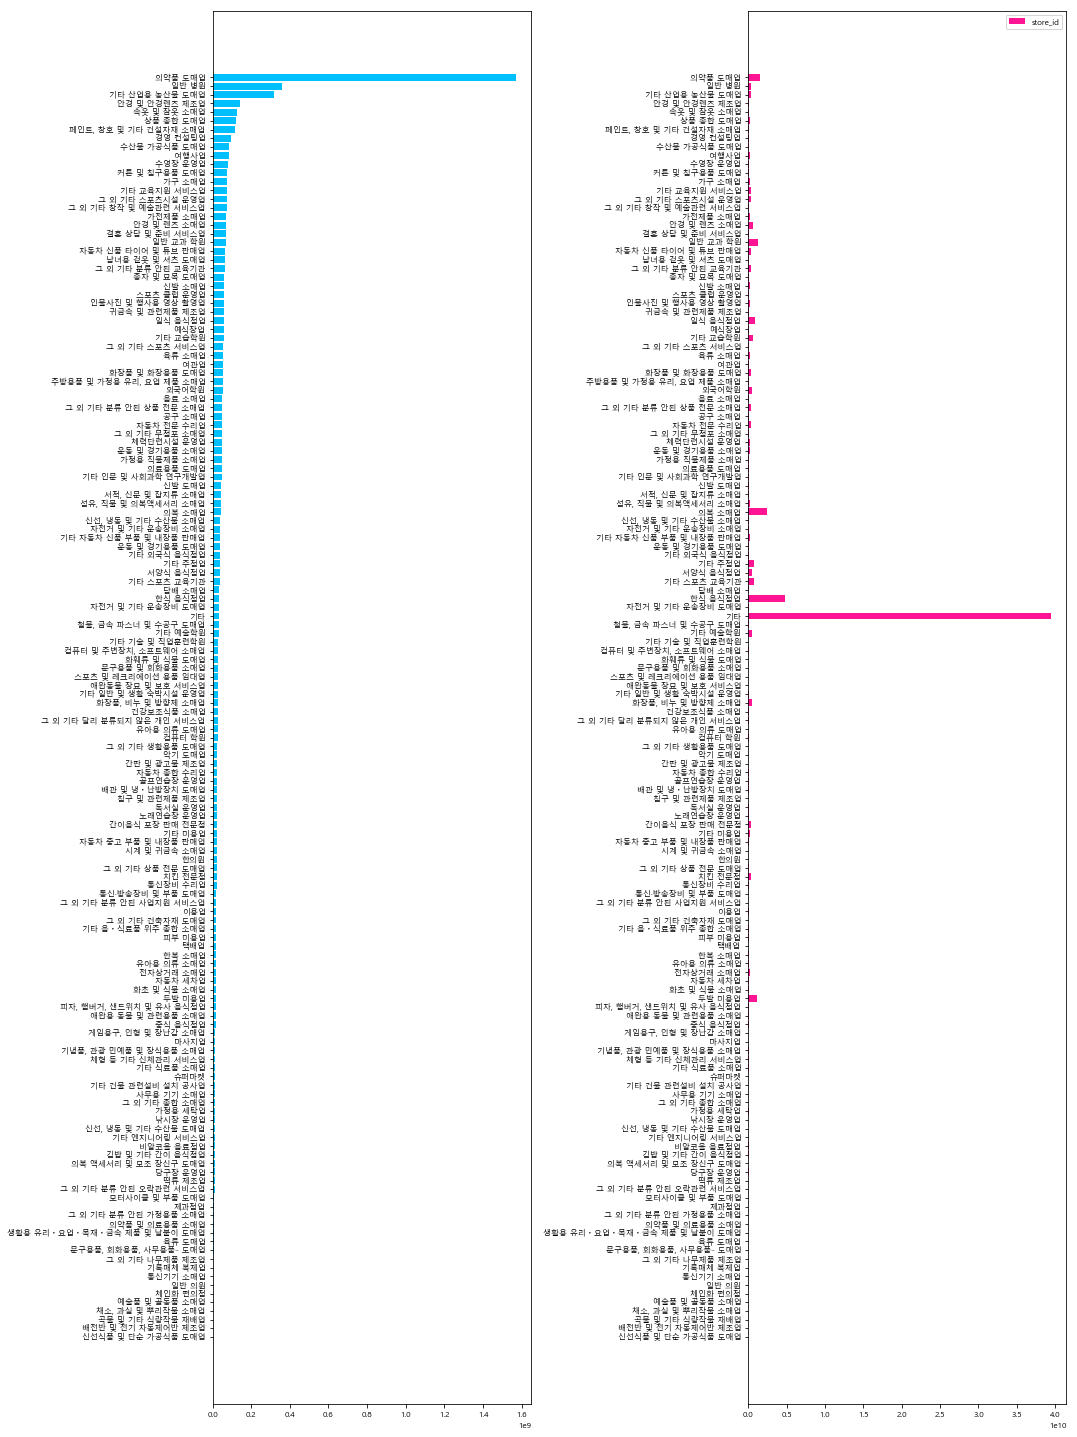

In [179]:
fig, ax = plt.subplots(1,2, figsize=[15,20])
ax[0].barh(width='amount_per_store', y='type_of_business', data=temp_join, label='amount per store', color='deepskyblue')
ax[1].barh(width='amount', y='type_of_business', data=temp_join, label='store_id', color='deeppink')
plt.legend()
plt.tight_layout()
plt.show()

* 의약품 도매업의 상점당 총 매출 평균이 압도적으로 높다.

### 거래

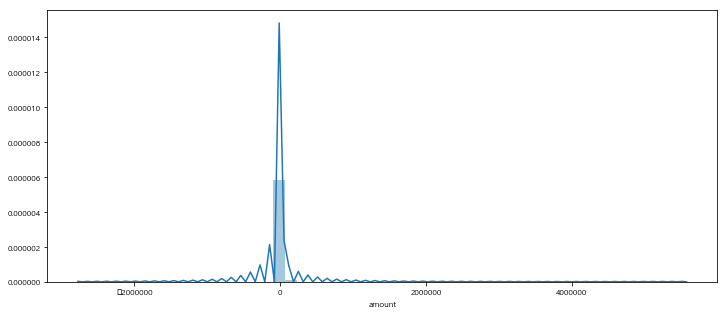

count    6.556613e+06
mean     1.043511e+04
std      3.104031e+04
min     -2.771429e+06
25%      2.142857e+03
50%      4.285714e+03
75%      8.571429e+03
max      5.571429e+06
Name: amount, dtype: float64

In [180]:
# 매출액
sb.distplot(train_df['amount'])
plt.show()
display(train_df['amount'].describe())

* 거래액은 정규화된것으로 보인다.

## feature engineering
* 날짜: 연도, 월, 일

In [208]:
# 상점 - 월매출합

# 연-월 변수 생성
train_df['year_month'] = train_df['transacted_date'].apply(lambda date: date[:7])
total_amount_by_store_year_month = train_df.groupby(['store_id', 'year_month'])['amount'].sum().reset_index()
total_amount_by_store_year_month.rename(columns={'amount': 'total_amount_for_month'}, inplace=True)

In [ ]:
# 해당 달의 금요일 수
# 해당 달의 


In [210]:
train_mod_df = pd.merge(train_df, total_amount_by_store_year_month, on=['store_id', 'year_month'], how='outer')

In [223]:
tmp = train_mod_df[train_mod_df['store_id']==50][['year_month', 'total_amount_for_month']]

In [224]:
sb.lineplot(x='year_month', y='total_amount_for_month', data=tmp)
plt.xticks(rotation=90)
plt.grid(True)
plt.show()